## Standard downstream pipeline for SL_Smart-seq3xpress data

In [1]:
# import modules
import os
import pandas as pd
import scipy.io
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#make a folder where to put the plots

out_folder="output/SS3x_example_General_stats"

os.makedirs(out_folder, exist_ok=True)

In [3]:
#input data and metadata
folder_path="./"
SS3x_sheet_path = folder_path + "input/SS3x_example_desc.txt"
matrix_path = folder_path + "output/star_mapping/SS3x_example_100K_subsampleSolo.out/Gene/raw/"
matrix_dir = folder_path + "output/star_mapping/SS3x_example_100K_subsampleSolo.out/Gene/raw/"

neg_matrix_path = folder_path + "output/star_mapping/SS3x_example_100K_negative_matrix.csv"

In [4]:
# import summary table from index hopping filtered matrix and the function to load the matrix itself
from bin.SL_SS3x_summary import SL_SS3x_summary_table, SL_SS3x_matrix, SL_SS3x_summary_table_hf, SL_SS3x_matrix_hf


In [5]:
Gene_counts_hf = SL_SS3x_summary_table_hf(SS3x_sheet_path,matrix_dir,neg_matrix_path)

In [6]:
Gene_counts = SL_SS3x_summary_table(SS3x_sheet_path,matrix_dir)

In [7]:
Gene_counts_hf.head(5)

,UMI_Total,Genes0_Total,Genes1_Total,Genes10_Total,ERCC_Total,Plate,Sorting,Spike-in,Type,Library_ID
Plate1_A1_single-cell_Yes_P10_or_N50,4673.0,1958,843,45,41.0,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50
Plate1_A2_single-cell_Yes_P10_or_N50,5770.0,2369,1003,72,95.0,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50
Plate1_A3_single-cell_Yes_P10_or_N50,5560.0,2199,953,76,100.0,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50
Plate1_A4_single-cell_Yes_P10_or_N50,7551.0,2733,1212,120,84.0,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50
Plate1_A5_single-cell_Yes_P10_or_N50,5507.0,2370,982,67,57.0,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50


In [8]:
Gene_counts.head(5)

,UMI_Total,Genes0_Total,Genes1_Total,Genes10_Total,ERCC_Total,Plate,Sorting,Spike-in,Type,Library_ID
Plate1_A1_single-cell_Yes_P10_or_N50,4861,2015,867,47,52,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50
Plate1_A2_single-cell_Yes_P10_or_N50,6070,2441,1043,83,102,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50
Plate1_A3_single-cell_Yes_P10_or_N50,5907,2299,990,83,108,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50
Plate1_A4_single-cell_Yes_P10_or_N50,7844,2794,1244,126,90,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50
Plate1_A5_single-cell_Yes_P10_or_N50,5762,2430,1019,73,61,Plate1,single-cell,Yes,P10_or_N50,single-cell_Yes_P10_or_N50


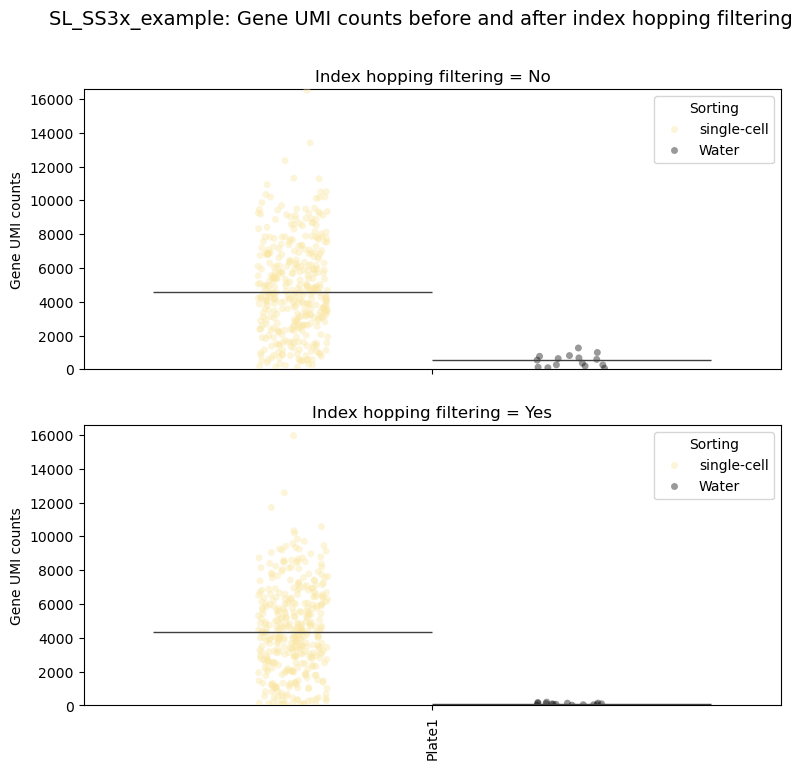

In [9]:
### Plot Gene UMI counts subdivided by Plate_ID and Type (single_cell or Water)

fig, axs = plt.subplots(nrows=2,figsize=(9,8),sharex=True)

fig.suptitle('SL_SS3x_example: Gene UMI counts before and after index hopping filtering', fontsize=14)

# ERCC counts splitted by plate and the plates splitted by Sorting (single-cell or Water)
p = sns.stripplot(x="Plate", y="UMI_Total", data=Gene_counts, palette=["#FAE6A3", "#000000"], hue="Sorting", dodge=True, ax=axs[0], alpha = 0.4)
m = sns.stripplot(x="Plate", y="UMI_Total", data=Gene_counts_hf, palette=["#FAE6A3", "#000000"], hue="Sorting", dodge=True, ax=axs[1], alpha = 0.4)

axs[0].set_title('Index hopping filtering = No')
axs[1].set_title('Index hopping filtering = Yes')

# set ylim for both plots based on the unfiltered counts from Gene_counts
axs[0].set(ylim=(0, (Gene_counts['UMI_Total'].max())+50))
axs[1].set(ylim=(0, (Gene_counts['UMI_Total'].max())+50))

# plot the median line
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': False},
        zorder=10,
        x="Plate",
        y="UMI_Total",
        data=Gene_counts,
        hue="Sorting",
        showfliers=False,
        showbox=False,
        showcaps=False,
        legend=False,
        ax=p)

# plot the median line
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': False},
        zorder=10,
        x="Plate",
        y="UMI_Total",
        data=Gene_counts_hf,
        hue="Sorting",
        showfliers=False,
        showbox=False,
        showcaps=False,
        legend=False,
        ax=m)

axs[0].set(xlabel='',ylabel='Gene UMI counts')
axs[1].set(xlabel='',ylabel='Gene UMI counts')

axs[0].tick_params(axis='x', labelrotation = 90)
axs[1].tick_params(axis='x', labelrotation = 90)


plt.show()

fig.savefig(out_folder + "/" + "SL_SS3x_example_Gene_UMI_counts_by_Plate_and_Sorting_hf_compare.png",bbox_inches="tight")

plt.close(fig)


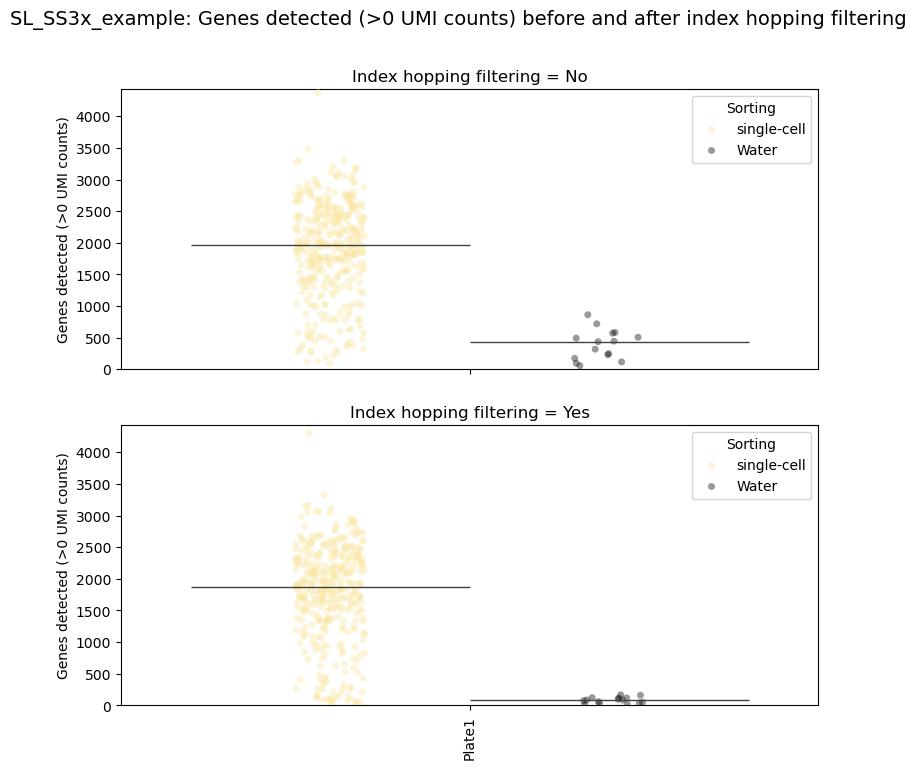

In [10]:
### Plot Genes detected (>0 UMI counts)subdivided by Plate_ID and Type (single_cell or Water)

fig, axs = plt.subplots(nrows=2,figsize=(9,8),sharex=True)

fig.suptitle('SL_SS3x_example: Genes detected (>0 UMI counts) before and after index hopping filtering', fontsize=14)

# ERCC counts splitted by plate and the plates splitted by Sorting (single-cell or Water)
p = sns.stripplot(x="Plate", y="Genes0_Total", data=Gene_counts, palette=["#FAE6A3", "#000000"], hue="Sorting", dodge=True, ax=axs[0], alpha = 0.4)
m = sns.stripplot(x="Plate", y="Genes0_Total", data=Gene_counts_hf, palette=["#FAE6A3", "#000000"], hue="Sorting", dodge=True, ax=axs[1], alpha = 0.4)

axs[0].set_title('Index hopping filtering = No')
axs[1].set_title('Index hopping filtering = Yes')

# set ylim for both plots based on the unfiltered counts from Gene_counts_no_hf
axs[0].set(ylim=(0, (Gene_counts['Genes0_Total'].max())+50))
axs[1].set(ylim=(0, (Gene_counts['Genes0_Total'].max())+50))

# plot the median line
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': False},
        zorder=10,
        x="Plate",
        y="Genes0_Total",
        data=Gene_counts,
        hue="Sorting",
        showfliers=False,
        showbox=False,
        showcaps=False,
        legend=False,
        ax=p)

# plot the median line
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': False},
        zorder=10,
        x="Plate",
        y="Genes0_Total",
        data=Gene_counts_hf,
        hue="Sorting",
        showfliers=False,
        showbox=False,
        showcaps=False,
        legend=False,
        ax=m)

axs[0].set(xlabel='',ylabel='Genes detected (>0 UMI counts)')
axs[1].set(xlabel='',ylabel='Genes detected (>0 UMI counts)')

axs[0].tick_params(axis='x', labelrotation = 90)
axs[1].tick_params(axis='x', labelrotation = 90)

plt.show()

fig.savefig(out_folder + "/" + "SL_SS3x_example_Genes_detected_by_Plate_and_Sorting_hf_compare.png",bbox_inches="tight")

plt.close(fig)


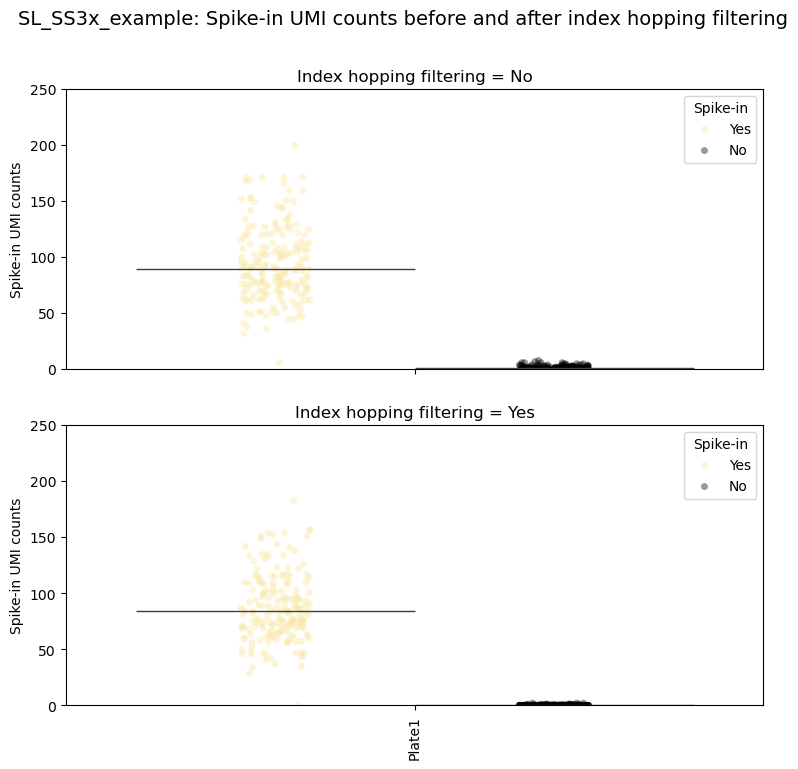

In [11]:
### Plot Spike-in UMI counts subdivided by Plate_ID and spike-in (Yes or No)

fig, axs = plt.subplots(nrows=2,figsize=(9,8),sharex=True)

fig.suptitle('SL_SS3x_example: Spike-in UMI counts before and after index hopping filtering', fontsize=14)

# ERCC counts splitted by plate and the plates splitted by if spike-in was added (Yes or No)
p = sns.stripplot(x="Plate", y="ERCC_Total", data=Gene_counts, palette=["#FAE6A3", "#000000"], hue="Spike-in", dodge=True, ax=axs[0], alpha = 0.4)
m = sns.stripplot(x="Plate", y="ERCC_Total", data=Gene_counts_hf, palette=["#FAE6A3", "#000000"], hue="Spike-in", dodge=True, ax=axs[1], alpha = 0.4)

axs[0].set_title('Index hopping filtering = No')
axs[1].set_title('Index hopping filtering = Yes')

# set ylim for both plots based on the unfiltered counts from Gene_counts
axs[0].set(ylim=(0, (Gene_counts['ERCC_Total'].max())+50))
axs[1].set(ylim=(0, (Gene_counts['ERCC_Total'].max())+50))

# plot the median line
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': False},
        zorder=10,
        x="Plate",
        y="ERCC_Total",
        data=Gene_counts,
        hue="Spike-in",
        showfliers=False,
        showbox=False,
        showcaps=False,
        legend=False,
        ax=p)

# plot the median line
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': False},
        zorder=10,
        x="Plate",
        y="ERCC_Total",
        data=Gene_counts_hf,
        hue="Spike-in",
        showfliers=False,
        showbox=False,
        showcaps=False,
        legend=False,
        ax=m)

axs[0].set(xlabel='',ylabel='Spike-in UMI counts')
axs[1].set(xlabel='',ylabel='Spike-in UMI counts')

axs[0].tick_params(axis='x', labelrotation = 90)
axs[1].tick_params(axis='x', labelrotation = 90)


plt.show()

fig.savefig(out_folder + "/" + "SL_SS3x_example_Spike-in_UMI_counts_by_Plate_and_Spike-in_hf_compare.png",bbox_inches="tight")

plt.close(fig)
